In [1]:
try:
    output_filepath
except:
    output_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/processed_2/'

In [2]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import data_loader

from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector

import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor
from yellowbrick.regressor import ResidualsPlot, PredictionError

import shap
plt.rcParams['savefig.facecolor']='white'

/usr/local/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [3]:
reduced_terms_list, df_model = data_loader(output_filepath)
df_model['year'] = df_model.year.astype(str)

In [4]:
controls = ['log_GFCF', 'log_wkn_population']
x_labels = controls + reduced_terms_list + ['year','country']
y_label = 'log_gdp'

In [5]:
# Split
X_train, X_test, y_train, y_test = train_test_split(df_model[x_labels], df_model[y_label], test_size=0.33, random_state=42, stratify=df_model[['country']] )

## Lasso

In [6]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Transform
# Impute numeric values with median 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median',add_indicator=True)),
    ('transformer', FunctionTransformer(None, validate=False))])

# Impute categorical features with 'missing' and one-hot-encode them
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value='missing',
                              add_indicator=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine all transformers in a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include=["float64", "int64"])),
        ('cat', categorical_transformer, make_column_selector(dtype_include=["object"])),])

regressor = Pipeline(steps=[ ('preprocessor', preprocessor),
                             ('Lasso', ElasticNet())])

param_grid = [
  {'Lasso__alpha': np.arange(0.1,0.9,0.1), 
   'Lasso__l1_ratio': np.arange(0.1,0.9,0.1),
   'Lasso__fit_intercept':[True],
   'Lasso__normalize': [True],
   'Lasso__selection':['cyclic', 'random'],
   'Lasso__max_iter':[10000]}]

reg = GridSearchCV(regressor, param_grid, scoring='r2')
reg.fit(X_train, y_train)
    

print('Best estimator alpha =', reg.best_estimator_['Lasso'].alpha)

print('Best estimator intercept =', reg.best_estimator_['Lasso'].intercept_)

pd.DataFrame({'variable':controls + reduced_terms_list + list(reg.best_estimator_['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(['year','country'])), 
              'coefficient':reg.best_estimator_['Lasso'].coef_}).sort_values(by='coefficient', ascending=False)

Best estimator alpha = 0.1
Best estimator intercept = 10.593482620335156


,variable,coefficient
80,country_USA,0.052063
3,financial_authorities,0.027081
52,country_JPN,0.026776
5,goods_authorities,0.025311
30,country_CHN,0.022578
...,...,...
38,country_EST,-0.014903
49,country_ISL,-0.021885
26,country_BRN,-0.023456
54,country_KHM,-0.035163


In [7]:
reg.score(X_test, y_test)

0.12735004788318416

## LightGBM

In [8]:
# Transform
# Impute numeric values with median 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median',add_indicator=True)),
    ('transformer', FunctionTransformer(None, validate=False))])

# Impute categorical features with 'missing' and one-hot-encode them
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value='missing',
                              add_indicator=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine all transformers in a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include=["float64", "int64"])),
        ('cat', categorical_transformer, make_column_selector(dtype_include=["object"])),])

regressor = Pipeline(steps=[ ('preprocessor', preprocessor),
                             ('GradientBoostingRegressor', GradientBoostingRegressor())])

model_pipe = TransformedTargetRegressor(regressor, func=None, inverse_func=None)

params = {'regressor__GradientBoostingRegressor__max_depth':[2,3,4],
          'regressor__GradientBoostingRegressor__learning_rate':[0.5,0.1,0.05, 0.01],
          'regressor__GradientBoostingRegressor__n_estimators':[int(n) for n in np.logspace(1,3.5,20)],
          'regressor__GradientBoostingRegressor__subsample':[0.8],
          'regressor__GradientBoostingRegressor__max_features':['auto']}
'''
params = {'regressor__GradientBoostingRegressor__learning_rate': [0.1],
          'regressor__GradientBoostingRegressor__max_depth':[2],
          'regressor__GradientBoostingRegressor__max_features': ['auto'],
          'regressor__GradientBoostingRegressor__n_estimators': [3162],
          'regressor__GradientBoostingRegressor__subsample': [0.8]}
          '''
model = GridSearchCV(model_pipe, param_grid=params, cv=5, verbose=1, n_jobs=4, scoring='r2')

model.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 248 tasks      | elapsed:   36.6s
[Parallel(n_jobs=4)]: Done 498 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 848 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 1200 out of 1200 | elapsed:  3.9min finished


GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('num',
                                                                                                              Pipeline(steps=[('imputer',
                                                                                                                               SimpleImputer(add_indicator=True,
                                                                                                                                             strategy='median')),
                                                                                                                              ('transformer',
                                                                                                                               FunctionTransformer())]),
               

In [9]:
model.score(X_test, y_test)

0.9958835167154569

<AxesSubplot:title={'center':'Residuals for GridSearchCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

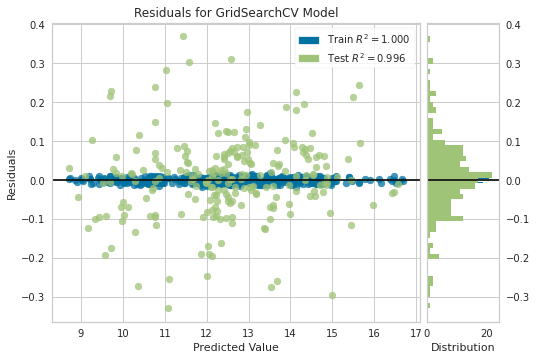

In [10]:
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 

save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'residuals_ml_model.png')
visualizer.show(outpath=save_to)

<AxesSubplot:title={'center':'Prediction Error for GridSearchCV'}, xlabel='$y$', ylabel='$\\hat{y}$'>

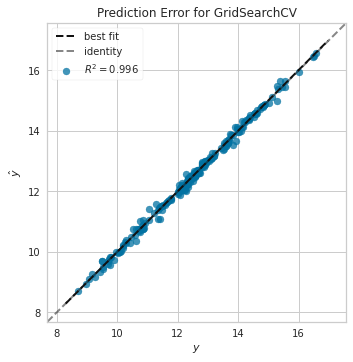

In [11]:
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)

save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'prediction_errors_ml_model.png')
visualizer.show(outpath=save_to)

In [12]:
n_points = 75
X_set = X_test.sample(n_points)

X_set = shap.sample(X_test, n_points)

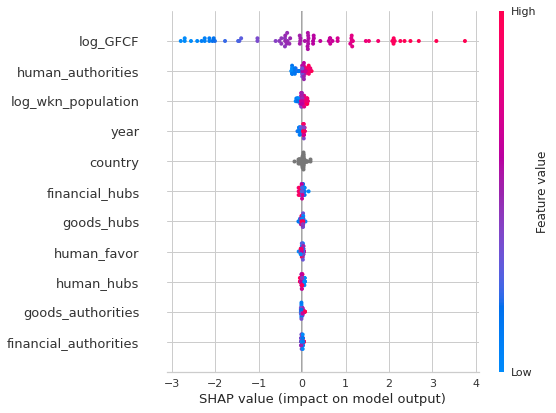

In [13]:
def model_predict(data_asarray):
    data_asframe =  pd.DataFrame(data_asarray, columns=X_test.columns)
    return model.best_estimator_.predict(data_asframe)

explainer = shap.KernelExplainer(model_predict, data=X_set.values, feature_names = x_labels, algorithm = 'auto')
shap_values = explainer.shap_values(X_set)

shap.summary_plot(shap_values, X_set, show=False)


save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'shap_values_levels.png')
plt.tight_layout()
plt.savefig(save_to)    
plt.show()

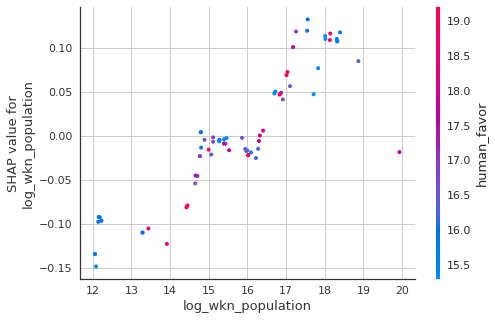

<Figure size 576x396 with 0 Axes>

In [14]:
shap.dependence_plot("log_wkn_population", shap_values, X_set, interaction_index='human_favor')
save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'shap_interaction_capital.png')
plt.tight_layout()
plt.savefig(save_to)    
plt.show()